             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.692308     32.54000

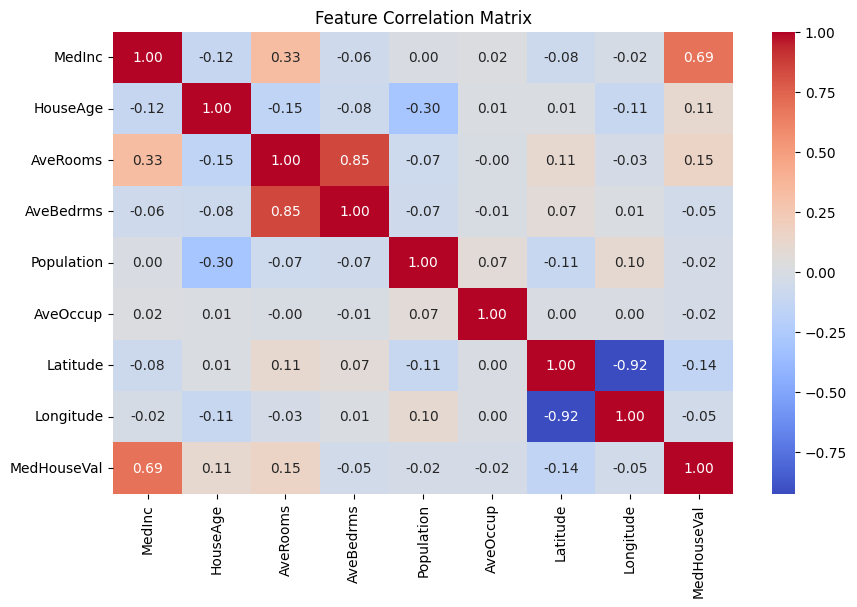

Training set: (16512, 8), Test set: (4128, 8)
Linear Regression trained successfully!
Decision Tree trained successfully!
Random Forest trained successfully!
XGBoost trained successfully!
                       RMSE       MAE  R2 Score
Linear Regression  0.646125  0.462074  0.575788
Decision Tree      0.610510  0.395608  0.621264
Random Forest      0.438145  0.283847  0.804932
XGBoost            0.408859  0.268278  0.830137
Best Random Forest: {'max_depth': None, 'n_estimators': 200}
Best XGBoost: {'learning_rate': 0.1, 'n_estimators': 200}
Model saved successfully!


In [54]:
##Part - 1

##Load Dataset


import pandas as pd
from sklearn.datasets import fetch_california_housing

# Load dataset
data = fetch_california_housing(as_frame=True)
df = data.frame

# Display first 5 rows
df.head()

"""##EDA"""

import matplotlib.pyplot as plt
import seaborn as sns

# Summary statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

# Check for missing values
df.isnull().sum()

# If missing values exist, fill them with median
df.fillna(df.median(), inplace=True)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

df_scaled.head()

df_scaled.to_csv("processed_data.csv", index=False)

"""##Part - 2"""

# Load Preprocessed Data
import pandas as pd
from sklearn.model_selection import train_test_split

# Load preprocessed data
df = pd.read_csv("processed_data.csv")

# Split into features (X) and target (y)
X = df.drop(columns=["MedHouseVal"])  # California Housing dataset target column
y = df["MedHouseVal"]

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# Train Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

# Train models
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained successfully!")

# Evaluate Models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Evaluate function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {"RMSE": rmse, "MAE": mae, "R2 Score": r2}

# Evaluate all models
results = {name: evaluate_model(model, X_test, y_test) for name, model in models.items()}

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Random Forest Hyperparameter Tuning
rf_params = {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20]}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=3, scoring="r2", n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Best Random Forest Model
best_rf = grid_rf.best_estimator_
print(f"Best Random Forest: {grid_rf.best_params_}")

# XGBoost Hyperparameter Tuning
xgb_params = {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2]}
grid_xgb = GridSearchCV(XGBRegressor(random_state=42), xgb_params, cv=3, scoring="r2", n_jobs=-1)
grid_xgb.fit(X_train, y_train)

# Best XGBoost Model
best_xgb = grid_xgb.best_estimator_
print(f"Best XGBoost: {grid_xgb.best_params_}")

# Save the Best Model
import pickle

# Choose best model
best_model = best_xgb if results_df.loc["XGBoost", "R2 Score"] > results_df.loc["Random Forest", "R2 Score"] else best_rf

# Save model
with open("house_price_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("Model saved successfully!")

In [3]:
!pip install onnxmltools onnx skl2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.0/329.0 kB 5.4 MB/s eta 0:00:00


In [6]:
import pickle
import onnxmltools
from skl2onnx.common.data_types import FloatTensorType

# Load your XGBoost model from the pickle file
with open("/content/House-Price-Prediction/house_price_model.pkl", "rb") as f:
    model = pickle.load(f)

# Force feature names to follow the pattern f0, f1, ... f7 (for 8 features)
n_features = 8
model.get_booster().feature_names = [f"f{i}" for i in range(n_features)]

# Define the expected input type for your model.
initial_type = [('input', FloatTensorType([None, n_features]))]

# Convert the XGBoost model to ONNX format using onnxmltools
onnx_model = onnxmltools.convert_xgboost(model, initial_types=initial_type)

# Save the converted ONNX model to a file
with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

print("Model successfully converted to ONNX and saved as 'model.onnx'.")


Model successfully converted to ONNX and saved as 'model.onnx'.


In [10]:
import onnxruntime as rt
import numpy as np

# Load the ONNX model
session = rt.InferenceSession("model.onnx")
input_name = session.get_inputs()[0].name
#print("ONNX model input name:", input_name)

# Prepare sample input as a numpy array of shape (1, 8) with type float32.
sample_input = np.array([[3.5, 15, 5.4, 1.2, 500, 3.0, 37.5, -122.0]], dtype=np.float32)

# Run inference using ONNX Runtime
pred_onx = session.run(None, {input_name: sample_input})
prediction_units = pred_onx[0][0]

# Convert prediction to a Python float using .item() and then to dollars
predicted_price = prediction_units.item() * 100000

print("Predicted House Price: ${:,.2f}".format(predicted_price))

Predicted House Price: $106,726.55
